# Import Libraries

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [175]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [176]:
from lazypredict.Supervised import LazyClassifier

# Clean and Explore

In [177]:
df = pd.read_csv("bank+marketing/bank/bank.csv", sep = ";")

In [178]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [179]:
print("No null values: ", df.isnull().sum().sum())

No null values:  0


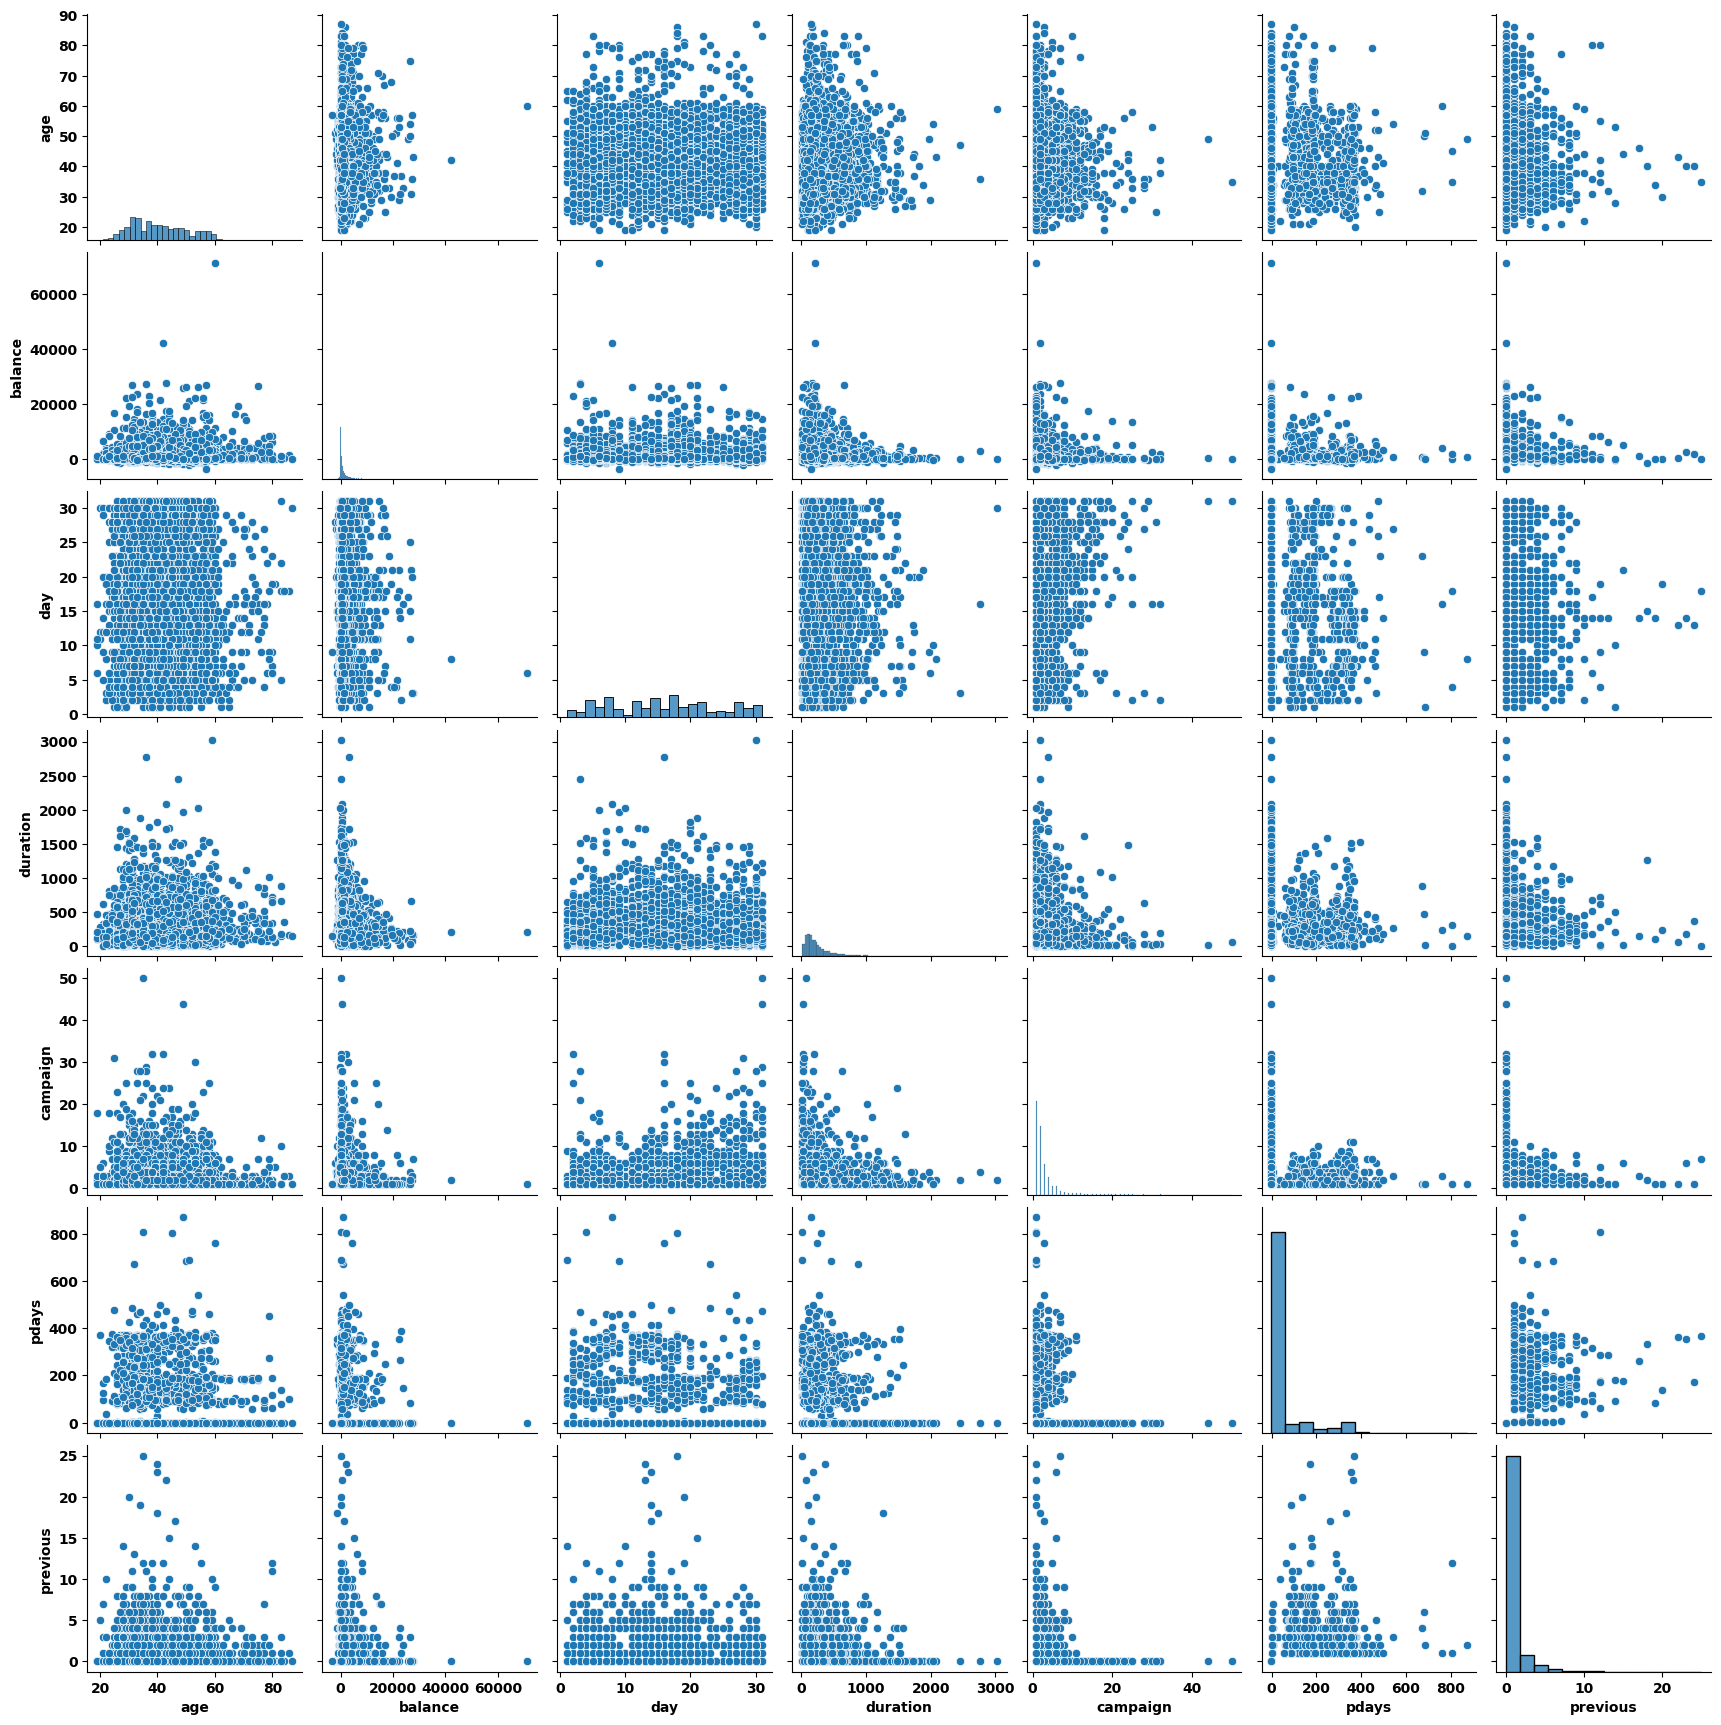

In [87]:
sns.pairplot(df)
plt.show()

In [180]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00
mean,41.17,1422.66,15.92,263.96,2.79,39.77,0.54
std,10.58,3009.64,8.25,259.86,3.11,100.12,1.69
min,19.00,-3313.00,1.00,4.00,1.00,-1.00,0.00
25%,33.00,69.00,9.00,104.00,1.00,-1.00,0.00
50%,39.00,444.00,16.00,185.00,2.00,-1.00,0.00
75%,49.00,1480.00,21.00,329.00,3.00,-1.00,0.00
max,87.00,71188.00,31.00,3025.00,50.00,871.00,25.00


In [181]:
df.sample()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
2700,64,retired,divorced,tertiary,no,890,no,no,cellular,3,jul,531,3,-1,0,unknown,no


In [182]:
def convert_yes_no(x):
    if x == "no":
        return 0
    elif x == "yes":
        return 1#
df["default"] = df["default"].apply(convert_yes_no).astype(int)
df["housing"] = df["housing"].apply(convert_yes_no).astype(int)
df["loan"] = df["loan"].apply(convert_yes_no).astype(int)
df["y"] = df["y"].apply(convert_yes_no).astype(int)

In [183]:
categorical_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
df.select_dtypes(exclude=[np.number])

,job,marital,education,contact,month,poutcome
0,unemployed,married,primary,cellular,oct,unknown
1,services,married,secondary,cellular,may,failure
2,management,single,tertiary,cellular,apr,failure
3,management,married,tertiary,unknown,jun,unknown
4,blue-collar,married,secondary,unknown,may,unknown
...,...,...,...,...,...,...
4516,services,married,secondary,cellular,jul,unknown
4517,self-employed,married,tertiary,unknown,may,unknown
4518,technician,married,secondary,cellular,aug,unknown
4519,blue-collar,married,secondary,cellular,feb,other


In [184]:
print("Job: ", df["job"].nunique())
print("Marital: ", df["marital"].nunique())
print("Education: ", df["education"].nunique())
print("Contact: ", df["contact"].nunique())
print("Month: ", df["month"].nunique())
print("Poutcome: ", df["poutcome"].nunique())

Job:  12
Marital:  3
Education:  4
Contact:  3
Month:  12
Poutcome:  4


In [ ]:
df = pd.get_dummies(df, columns=["job", "marital", "education", "contact", "month", "poutcome"])

KeyError: "['job', 'marital', 'education', 'contact', 'month', 'poutcome'] not found in axis"

In [ ]:
print("Low variance columns: ")
low_variance = []
for col in df.columns:
    if df[col].var() < 0.01:
        low_variance.append(col+" "+str(df[col].var()))
print(low_variance)

Low variance columns: 
['job_unknown 0.008336416291328764', 'month_dec 0.004405204424583017']


In [187]:
print("Drop job unknown also for redundancy, keep months")
low_variance = ["job_unknown"]
df.drop(columns = low_variance, inplace = True)

Drop job unknown also for redundancy, keep months


In [188]:
print("Höchste Korrelation mit Target y: ")
correlation = df.corr()
correlationy = correlation["y"]
correlationy = correlationy[correlationy > 0.1]
correlationy = correlationy[correlationy < 1]
print(correlationy.sort_values(ascending = False))

Höchste Korrelation mit Target y: 
duration           0.40
poutcome_success   0.28
month_oct          0.15
contact_cellular   0.12
previous           0.12
pdays              0.10
month_mar          0.10
Name: y, dtype: float64


In [189]:
print("Höchste Korrelation zwischen Features: ")
correlation = df.corr()
correlation = correlation[correlation > 0.7]
correlation = correlation[correlation < 1]
correlation.dropna(axis = 0, how = "all", inplace = True)
correlation.dropna(axis = 1, how = "all", inplace = True)
correlation.replace(np.nan, '', inplace = True)
correlation

Höchste Korrelation zwischen Features: 


,pdays,poutcome_failure
pdays,,0.71
poutcome_failure,0.71,


In [190]:
print("Höchste Korrelation zwischen Features: ")
correlation = df.corr()
correlation = correlation[correlation < -0.7]
correlation = correlation[correlation > -1]
correlation.dropna(axis = 0, how = "all", inplace = True)
correlation.dropna(axis = 1, how = "all", inplace = True)
correlation.replace(np.nan, '', inplace = True)
correlation

Höchste Korrelation zwischen Features: 


,pdays,marital_married,marital_single,contact_cellular,contact_unknown,poutcome_failure,poutcome_unknown
pdays,,,,,,,-0.87
marital_married,,,-0.76,,,,
marital_single,,-0.76,,,,,
contact_cellular,,,,,-0.86,,
contact_unknown,,,,-0.86,,,
poutcome_failure,,,,,,,-0.74
poutcome_unknown,-0.87,,,,,-0.74,


In [191]:
print("Droppe hoch korrelierte Werte")
col_drop = ["marital_single", "poutcome_unknown", "contact_unknown", "poutcome_failure"]
df.drop(columns = col_drop, inplace = True)

Droppe hoch korrelierte Werte


# Simple Logistic Regression

In [192]:
X = df.drop(columns = "y")
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [193]:
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print(classification_report(y_test, y_pred))

Mean Squared Error:  0.11491712707182321
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       807
           1       0.44      0.24      0.32        98

    accuracy                           0.89       905
   macro avg       0.68      0.60      0.63       905
weighted avg       0.86      0.89      0.87       905



In [194]:
from sklearn.metrics import roc_auc_score
roc_value = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", np.round(roc_value, 3))

ROC AUC:  0.604


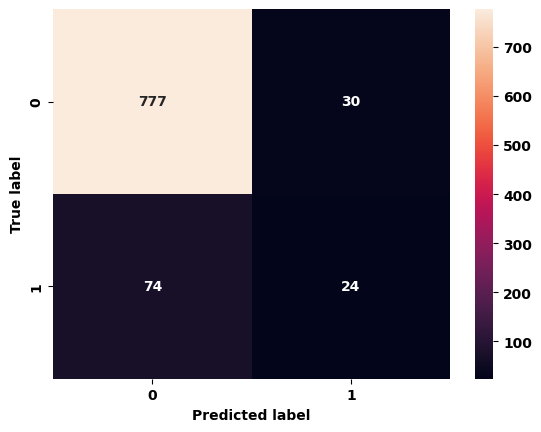

In [195]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Lazy Classifier

In [196]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 32/32 [00:04<00:00,  7.52it/s]

[LightGBM] [Info] Number of positive: 423, number of negative: 3193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 3616, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116980 -> initscore=-2.021344
[LightGBM] [Info] Start training from score -2.021344


In [197]:
models.sort_values("ROC AUC", ascending = False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.83,0.77,0.77,0.85,0.03
XGBClassifier,0.90,0.66,0.66,0.89,0.16
LGBMClassifier,0.90,0.65,0.65,0.89,0.13
GaussianNB,0.84,0.65,0.65,0.85,0.02
BaggingClassifier,0.90,0.65,0.65,0.89,0.12
QuadraticDiscriminantAnalysis,0.85,0.65,0.65,0.85,0.03
DecisionTreeClassifier,0.86,0.65,0.65,0.86,0.05
Perceptron,0.79,0.64,0.64,0.82,0.03
PassiveAggressiveClassifier,0.88,0.63,0.63,0.87,0.03


In [173]:
# 0.77
# 0.58